In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist
from functools import partial

In [2]:
data_path = '/pscratch/sd/a/azaidi/new-dt/nsys/spec_freq_df.pkl'
df = pd.read_pickle(data_path)
df = df.sort_values('length_key').reset_index(drop=True)
df['num_unique'] = df.unique_species.map(len)
df.shape

(295617, 3)

In [3]:
df.head(5)

,length_key,unique_species,num_unique
0,20,[30420],1
1,23,[29255],1
2,25,"[29255, 33254]",2
3,26,[30420],1
4,27,"[21836, 29255, 33254]",3


In [159]:
len(df.unique_species)

295617

In [4]:
spec_lbls_stacked = np.hstack(df.unique_species.values)
spec_lbls_stacked.shape, spec_lbls_stacked[:4]

((8240475,), array([30420, 29255, 29255, 33254]))

In [91]:
#plt.hist(df.length_key, bins=100);
#plt.hist(np.log10(df.length_key), bins=100);
#np.log10(df.length_key)[:10];

In [5]:
#this will bin our labels - since it's sorted we can easily extract indexes
bin_sizes , _ = np.histogram(np.log10(df.length_key), bins=100)
len(bin_sizes), bin_sizes[:4]

(100, array([1, 3, 2, 2]))

In [162]:
bin_sizes[:10]

array([ 1,  3,  2,  2,  2,  4,  4,  8,  7, 10])

THIS IS WRONG! -- not needed for saturation calc, but come back around and fix

In [154]:
#this will get the start and stop index values for spec_lbls_stacked
idx_holder = [0,]
for count in bin_sizes:
    holder_len = len(idx_holder)
    #idx_holder.append(idx_holder[holder_len - 1] + count)
    idx_holder.append(idx_holder[holder_len - 1] + count)
idx_holder[:3], idx_holder[-3:], len(idx_holder)

([0, 1, 4], [295604, 295614, 295617], 101)

In [210]:
#bin_sizes

In [153]:
idx_holder[:12]

[0, 1, 4, 6, 8, 10, 14, 18, 26, 33, 43, 55]

In [174]:
def get_intersection_card(x,y):
    return len(np.intersect1d(x,y))

In [175]:
one_bin = spec_lbls_stacked[idx_holder[0]]
two_bin = spec_lbls_stacked[idx_holder[1]: idx_holder[2]]
one_bin, two_bin, get_intersection_card(one_bin, two_bin)

(30420, array([29255, 29255, 33254]), 0)

In [7]:
def get_binned_spec(idx_holder):
    bins, prev_idx = [], 0
    for idx in range(len(idx_holder[1:])):
        bins.append(spec_lbls_stacked[idx_holder[prev_idx]: idx_holder[idx]])
        prev_idx = idx
    bins.append(spec_lbls_stacked[idx_holder[-2]: idx_holder[-1]])
    return bins[1:]

In [176]:
#spec_lbls_stacked[idx_holder[-2]: idx_holder[-1]]

In [8]:
binned_species = get_binned_spec(idx_holder)
bin_lens = np.asarray([len(x) for x in binned_species])
len(binned_species), len(bin_lens) == len(bin_sizes)

(100, True)

In [165]:
np.hstack(df.unique_species.iloc[1:3].values)

array([29255, 29255, 33254])

All we need for saturation calculation is the bin sizes...
bin_sizes , _ = np.histogram(np.log10(df.length_key), bins=100)

In [209]:
bin_sizes , _ = np.histogram(np.log10(df.length_key), bins=100)
bin_sizes[:5]

array([1, 3, 2, 2, 2])

In [193]:
def get_saturation_bin(num_species):
    base_idx = 0
    holder = []
    for idx, bin_size in enumerate(bin_sizes):
        next_idx = base_idx + bin_size
        holder.append(np.hstack(df.unique_species.iloc[base_idx:next_idx].values))
        base_idx = next_idx
        if len(set(np.hstack(holder))) >= num_species : 
            return (idx); break

In [207]:
num_species = df.unique_species.map(max).max() + 1
num_species

65703

In [208]:
get_saturation_bin(num_species)

99

In [191]:
x_base_idxs = np.arange(5000, 66000, 5000)
x_base_idxs

array([ 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000,
       50000, 55000, 60000, 65000])

In [203]:
num_bins_for_saturation = [get_saturation_bin(x) for x in x_base_idxs]

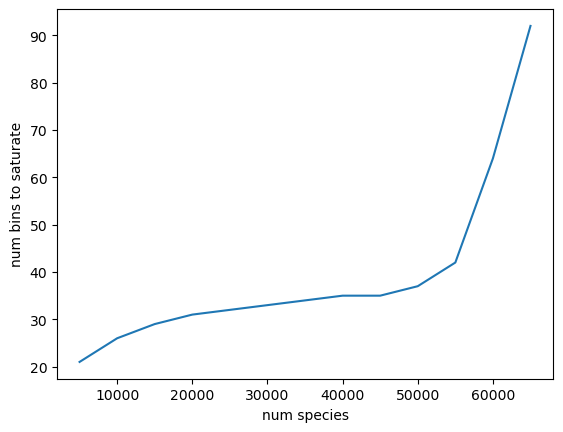

In [205]:
plt.plot(x_base_idxs, num_bins_for_saturation)
plt.xlabel('num species')
plt.ylabel('num bins to saturate');

# Come back and check work below :)

In [55]:
#bin_func = partial(np.histogram, minlength = 65703)
#bin_matrix = np.stack(df.unique_species.map(bin_func).map(np.asarray))
#bin_matrix.shape

In [66]:
def get_union_card(x,y):
    return len(set(x).union(set(y)))

def get_jabccard_sim_score(x,y):
    intersect_card = get_intersection_card(x,y)
    union_card = get_union_card(x,y)
    return intersect_card/union_card

In [177]:
card_holder = np.zeros((len(binned_species), len(binned_species)))
card_holder.shape

for x in range(len(binned_species)):
    f = partial(get_intersection_card, binned_species[x])
    for y in range(x+1, len(binned_species)):
        card_val = f(binned_species[y])
        card_holder[x, y] = card_val

In [179]:
np.set_printoptions(precision=1, linewidth=140)
card_holder.astype(int)

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [190]:
#lets just check that there's some union between bins
card_holder.astype(int).sum(0)

array([    0,     0,     1,     2,     4,     4,     1,     7,     9,     6,    17,    19,    29,    28,    13,    13,    27,    53,    85,
          92,   128,   165,   179,   244,   268,   245,   270,   369,   450,   502,   555,   689,   748,   776,  1004,  1126,  1274,  1440,
        1510,  1301,   649,  1046,  1374,  1835,  2273,  2938,  3494,  4219,  5070,  6006,  7307,  7972,  9488, 10642, 12676, 14255, 16283,
       17405, 19964, 22670, 25447, 26680, 30005, 33431, 29989, 34117, 38234, 41765, 44535, 47192, 48894, 48959, 48357, 46775, 44045, 39953,
       22156, 19604, 17979, 15294, 12265, 10382,  9029,  8439,  7966,  5913,  6827,  8113,  9278,  8511,  9450,  7105,  5430,  4305,  2830,
        2252,  1213,   398,   174,    74])

In [196]:
card_holder.shape

(100, 100)

Object `card_holder.to_csv` not found.


In [193]:
#plot the same
#plt.hist(pd.DataFrame(card_holder).max(0));